# **<span style="color: #87CEEB;"> CS437/CS5317/EE414/EE513 Deep Learning Programming Assignment 1</span>**

# <span style="color: #9370DB;">**Submission Guidelines**</span>

- <span style="color: #9370DB;">Please rename the file to `<RollNumber>_PA1_2_2`.</span>
- <span style="color: #9370DB;">Please also submit a **.py** file of every Notebook. You can do this by exporting your **ipynb** to a Python script.</span>
- <span style="color: #9370DB;">Please submit a zipped folder of both your Jupyter Notebooks and Python script files.</span>




### Name: Zaeem Yousaf
### Roll Number: 23030021

<h1><b> Part 2 Task 2 : Convolutional Neural Networks (CNNs) using Pytorch<span style="color: #9370DB;"> (50 Points Total)</span></b></h1>

`Note` : # **<span style="color: #87CEEB;"> You will be requiring a GPU for this task</span>**
- You can use either the Google Colab T4-GPU or the Kaggle GPU

Convolutional Neural Networks (CNNs) are the backbone of modern computer vision, excelling at tasks such as image classification, object detection, and image segmentation. Unlike traditional fully connected neural networks, CNNs leverage local receptive fields, weight sharing, and hierarchical feature extraction to efficiently process visual data. This enables them to automatically learn spatial hierarchies of features, capturing simple patterns like edges in early layers and more complex structures in deeper layers.

The development of CNNs dates back to the 1980s with early work on weight sharing and local connectivity, but they gained widespread recognition after the success of AlexNet in the 2012 ImageNet competition. Since then, architectures like VGG, ResNet, and EfficientNet have further refined CNNs, making them both deeper and more computationally efficient.

In this assignment, we'll start by focusing on image classification—a classic application of CNNs. You will explore different types of convolutions such as 1x1 convolutions, often used for dimensionality reduction, and bottleneck blocks, which are a combination of these techniques to make deep networks more efficient. Through these exercises, you'll gain a hands-on understanding of the various convolutional operations and how they contribute to building powerful and efficient CNN architectures.

We will be using PyTorch for this assignment and the other two parts. Hence, it is recommended you brush up on your PyTorch before starting this assignment.

Here is a list of resources to help you with this part:
- [CS231n CNNs](https://cs231n.github.io/convolutional-networks/) - A great writeup on CNNs, both for beginners and people looking for a refresher.
- [DeepLearningAI Intro to CNNs](https://youtube.com/playlist?list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&si=VI-V6EPFE-6DvAzE) - A free YouTube playlist to understand CNNs and other topics in Computer Vision.
- [learnpytorch.io](https://www.learnpytorch.io/) - an online and free book for learning PyTorch. Take out a few hours to go through the first few chapters till you are familiar with Image Classification.
- [PyTorch Official Intro to Image Classification](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) - If you want a faster primer, this will be helpful.

### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

def get_num_params(model: nn.Module):
    '''Returns the number of parameters in a PyTorch model'''
    return sum(p.numel() for p in model.parameters())

### Loading the Data

For this assignment, we will be using the `CIFAR-10 dataset`, a widely used benchmark in computer vision. CIFAR-10 consists of 60,000 color images (32×32 pixels) across 10 categories, including airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset is small enough for quick training while still being diverse enough for meaningful experimentation.

We will use `torchvision.datasets` to automatically download and load CIFAR-10 in PyTorch.

**1. Data Preprocessing and Augmentation**

To ensure our CNN learns robust features, we apply the following preprocessing steps:

- Resizing: Since some CNN architectures expect larger input sizes, we resize images to 224×224 pixels.
- Normalization: We scale pixel values to the range [-1, 1] using mean and standard deviation normalization.
- Unlike extensive augmentations (like random cropping and flipping), we keep preprocessing minimal in this stage to focus on core CNN learning.

**2. Efficient Data Loading**

We use PyTorch’s DataLoader to handle:

- Batching – Feeding multiple images at once for efficient computation.
- Shuffling – Ensuring a different sample order each epoch to prevent the model from memorizing sequences.
- Parallel Loading – Speeding up data access.

`We define`:

- train_dl → Training DataLoader with shuffling enabled.
- test_dl → Testing DataLoader with a fixed order for evaluation.

**3. Visualizing a Batch of Images**

To confirm that our dataset is loaded correctly, we visualize a batch of training images using `torchvision.utils.make_grid()`. This helps us:
- Ensure that images are properly resized and normalized.
- Check if the dataset is being loaded correctly before training.

📌 You don’t need to implement anything for this part. Simply run the provided code to inspect the dataset.

In [2]:
# Install Dependencies (if needed uncomment the line below)
# !pip install torch torchvision matplotlib

In [3]:
# Define root directory for dataset storage
root = "./data"

# Define transformations: Resizing and Normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize CIFAR-10 images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset with transformations
trainset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


In [5]:
# Define batch size
batch_size = 32

# Create DataLoaders for efficient batch processing
train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


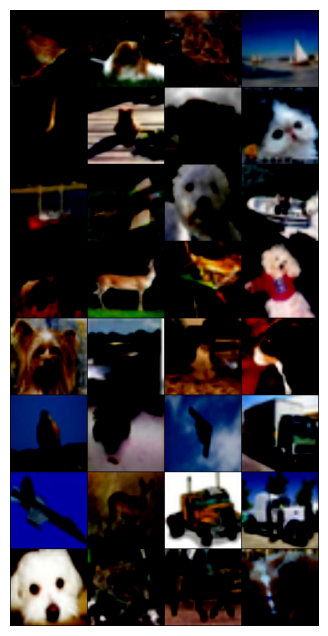

In [6]:
# Get a batch of training images
images, labels = next(iter(train_dl))

# Create a grid of images
grid_img = torchvision.utils.make_grid(images, nrow=4)  # Arrange images in a 4-column grid

# Display the images
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))  # Move channel axis to the end for correct display
plt.axis('off')
plt.show()

<h1><b> CNN using Pytorch <span style="color: #9370DB;">(30 Points)</span></b></h1>

Now that our data pipeline is set up, it's time to build your first Convolutional Neural Network (CNN). In this part of the assignment, you'll design and train a plain CNN from scratch using `PyTorch`. This will help you understand how convolutional layers, pooling, activation functions, and fully connected layers work together to extract features and classify images.

🔹 Your Task
You will construct a CNN using fundamental PyTorch layers:

- nn.Conv2d – Performs convolution to extract features.
- nn.MaxPool2d – Reduces spatial dimensions while preserving key information.
- nn.ReLU – Introduces non-linearity to capture complex patterns.
- nn.Linear – Fully connected layers for classification.

🔹 Network Architecture
A simple yet effective CNN can follow a structure similar to classic architectures like AlexNet or VGG, where we alternate between convolutional layers, pooling layers, and activation functions before passing the features to a fully connected classifier.

A typical sequence looks like this:

- Convolutional Layer (Conv2d) – Extracts spatial features from images.
- ReLU Activation (ReLU) – Introduces non-linearity.
- Pooling Layer (MaxPool2d) – Downsamples feature maps to reduce computational load.
- Repeat – Stacking more convolutional layers allows deeper feature extraction.
- Flattening – Converts the final feature maps into a 1D vector.
- Fully Connected Layers (Linear) – Uses extracted features to classify images.

Your task is to build this CNN and train it on the `CIFAR-10 dataset`.

🔹 What to Focus On
At this stage, there’s no need to use advanced techniques like batch normalization or dropout. The goal is to:
- ✅ Understand how CNN layers interact.
- ✅ Implement a simple yet functional CNN.
- ✅ Train the network and observe its performance.

In later tasks, we’ll explore more advanced architectures, optimizations, and sparse CNNs. For now, focus on getting your first CNN up and running! 🚀

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super(SimpleCNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # Output: 32x224x224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # Output: 32x112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: 64x112x112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # Output: 64x56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Output: 128x56x56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)         # Output: 128x28x28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                  # 128*28*28 = 100352
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model and move it to GPU (if available)
model = SimpleCNN(num_classes=10).to(device)

# Do a dummy forward pass on a batch from the DataLoader
# This will help you debug shape errors (Uncomment the lines Below to test)
# x = next(iter(train_dl))[0]
# logits = model(x)
# print(logits.shape)

print(f"Model has {get_num_params(model)} parameters.")

Using device: cuda
Model has 51479114 parameters.


In [10]:
# Instantiate loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


## **🔹 Understanding the Training Process in PyTorch**
Before jumping into training, it's important to understand the **core components** involved in optimizing a deep learning model. If you're new to PyTorch, we recommend reviewing an **introductory tutorial on image classification** to get familiar with key functions and concepts.  

### **📌 What Happens During Training?**
In the next cell, you'll train your CNN using:  
- **Loss Function: `nn.CrossEntropyLoss`**  
  - This is the standard loss function for **multi-class classification** tasks.
- **Optimizer: `Adam`**  
  - A widely used optimization algorithm that helps adjust the model’s weights efficiently.  
  - We’ll set the learning rate to **`3e-4`**, a commonly used value that balances stability and speed.  
- **Epochs: 10**  
  - This means the model will go through the entire dataset **10 times**.  
  - This should be enough to observe significant improvements in accuracy without excessive training time or overfitting.

### **📌 Expected Performance**
Our goal is to reach around **67% validation accuracy**. This might seem modest, but remember:  
- **We're training from scratch**—without transfer learning or pre-trained models.  
- **Early benchmarks matter**—achieving this accuracy shows that the model is **learning and generalizing** well.  
- **Further optimizations can improve results** in later experiments.  

### **📌 Running the Training on GPU**
To **speed up training**, it’s essential to use a **GPU** (if available).  
🔹 **How to ensure everything is on the GPU?**  
- Move **your model** to the GPU using: `model.to(device)`
- Move your data (images and labels) to the GPU before training: `images, labels = images.to(device), labels.to(device)`


In [11]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total

    return epoch_loss, epoch_acc


@torch.inference_mode()
def eval_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              device: str):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total

    return epoch_loss, epoch_acc


In [12]:
num_epochs = 10

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_step(model, train_dl, criterion, optimizer, device)
    val_loss, val_acc = eval_step(model, test_dl, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 1.4318 | Train Acc: 0.4885 | Val Loss: 1.1878 | Val Acc: 0.5813
Epoch 2/10 | Train Loss: 1.0045 | Train Acc: 0.6444 | Val Loss: 1.0298 | Val Acc: 0.6334
Epoch 3/10 | Train Loss: 0.6768 | Train Acc: 0.7628 | Val Loss: 1.0886 | Val Acc: 0.6404
Epoch 4/10 | Train Loss: 0.3505 | Train Acc: 0.8786 | Val Loss: 1.3108 | Val Acc: 0.6439
Epoch 5/10 | Train Loss: 0.1561 | Train Acc: 0.9477 | Val Loss: 1.8400 | Val Acc: 0.6359
Epoch 6/10 | Train Loss: 0.1080 | Train Acc: 0.9634 | Val Loss: 2.0924 | Val Acc: 0.6320
Epoch 7/10 | Train Loss: 0.0878 | Train Acc: 0.9707 | Val Loss: 2.2670 | Val Acc: 0.6369
Epoch 8/10 | Train Loss: 0.0850 | Train Acc: 0.9727 | Val Loss: 2.4993 | Val Acc: 0.6268
Epoch 9/10 | Train Loss: 0.0654 | Train Acc: 0.9792 | Val Loss: 2.5282 | Val Acc: 0.6306
Epoch 10/10 | Train Loss: 0.0706 | Train Acc: 0.9776 | Val Loss: 2.7968 | Val Acc: 0.6288


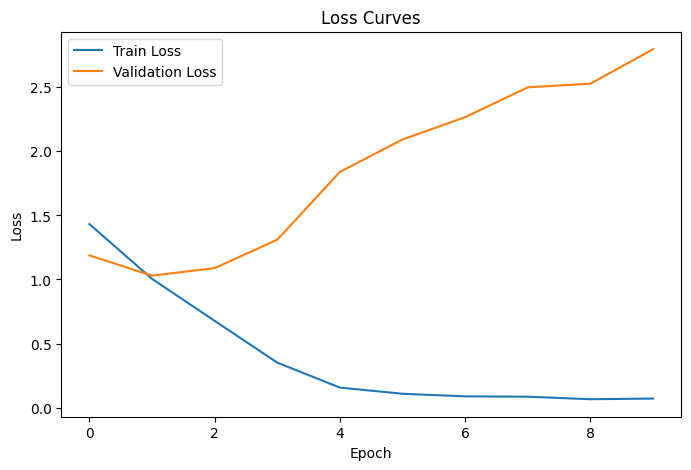

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

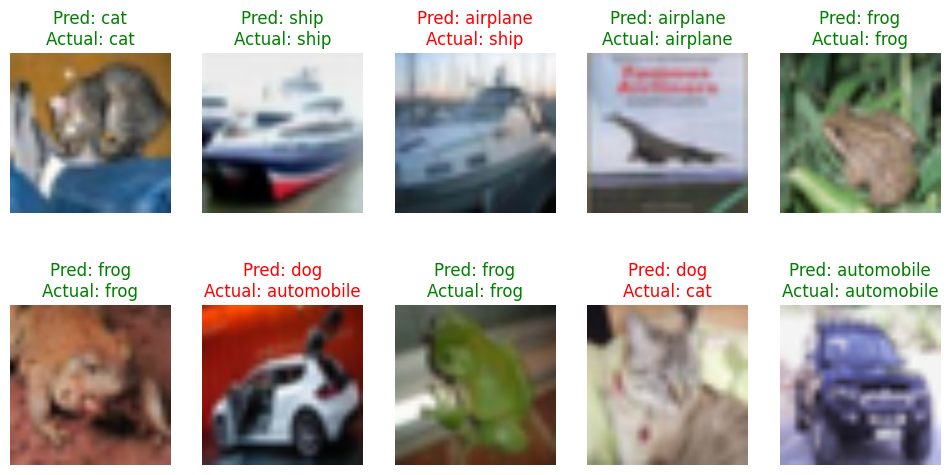

In [14]:
# Function to display images with predictions
def visualize_predictions(model, test_dl, num_images=10):
    model.eval()  # Set model to evaluation mode
    images, labels = next(iter(test_dl))  # Get a batch of test images
    images, labels = images.to(device), labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Convert images for display (unnormalize)
    images = images.cpu().numpy().transpose((0, 2, 3, 1))
    images = (images * 0.5) + 0.5  # Reverse normalization

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        ax.imshow(images[i])
        ax.set_title(f"Pred: {classes[predicted[i].item()]}\nActual: {classes[labels[i].item()]}",
                     color=("green" if predicted[i] == labels[i] else "red"))
        ax.axis('off')

    plt.show()

# Run visualization
visualize_predictions(model, test_dl)


## **Using 1x1 Convolutions to create Bottlenecks** <span style="color: #9370DB;"> **(20 Points)**</span>

1x1 convolutions are a powerful tool in modern deep learning architectures, particularly when working with convolutional neural networks. Unlike traditional convolutions, which typically use larger kernels like 3x3 or 5x5, a 1x1 convolution applies a single filter across each pixel location, effectively operating on the depth dimension of the input tensor. This seemingly simple operation has been widely adopted in advanced architectures like InceptionNet and MobileNet due to its ability to reduce computational complexity while retaining valuable information.

One of the primary uses of 1x1 convolutions is to downsample the number of channels in a tensor. For instance, imagine you have a tensor with a large number of channels after applying several convolutions. A 1x1 convolution can be used to reduce the channel dimension, significantly decreasing the computational overhead before applying more complex operations like a 3x3 convolution. After the 3x3 convolution, another 1x1 convolution can be applied to upsample the channels back to their original size or to a desired dimension. This three-stage approach—downsampling, applying the 3x3 convolution, and then upsampling—forms the basis of the bottleneck block, which is a cornerstone of many efficient deep learning models.

To illustrate the efficiency of this method, let’s consider a small numerical example. Suppose you have an input tensor with 256 channels, and you want to apply a 3x3 convolution that outputs 512 channels. A direct 3x3 convolution would involve $256 \times 512 \times 3 \times 3 = 1,179,648$ parameters. However, if you first downsample the 256 channels to 64 using a 1x1 convolution, apply the 3x3 convolution on the reduced tensor, and then upsample back to 512 channels with another 1x1 convolution, the total number of parameters becomes $256 \times 64 \times 1 \times 1 + 64 \times 512 \times 3 \times 3 + 512 \times 256 \times 1 \times 1 = 16,384 + 294,912 + 131,072 = 442,368$ parameters. As you can see, this approach requires significantly fewer parameters than the direct method, even though it introduces additional layers. This not only reduces the model’s size but also makes it more efficient to train.

Your next task will be to implement this type of architecture using bottleneck blocks, which were popularized by the ResNet architecture. ResNet, introduced in the paper ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385), leverages bottleneck blocks to allow the construction of very deep networks while maintaining computational efficiency. The residual connections in ResNet help in mitigating the vanishing gradient problem, making it feasible to train networks with hundreds or even thousands of layers.

By implementing bottleneck blocks in your model, you’ll explore how deeper architectures can be both powerful and efficient, leveraging the combination of 1x1 convolutions and residual connections to push the boundaries of what CNNs can achieve.

In [15]:
# Instantiate a tensor for demonstration
in_channels = 64
h, w = 224, 224
bs = 8
out_channels = 256

x = torch.randn(bs, in_channels, h, w)


In [16]:
# A regular 3x3 Conv
layer = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
layer(x).shape

torch.Size([8, 256, 224, 224])

In [17]:
# The bottleneck using 1x1 Convs - note the same shape as above
bottleneck_channels = in_channels // 4
layer = nn.Sequential(
    nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, padding=0, bias=False),
    nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=1, padding=1, bias=False),
    nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
)

layer(x).shape

torch.Size([8, 256, 224, 224])

In [18]:
# Some helper functions to help you tinker with comparing a single 3x3 conv against the three-stage approach
def get_standard_conv(in_channels: int,
                        out_channels: int):

    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

def get_bottleneck_conv(in_channels: int,
                        out_channels: int,
                        bottleneck_channels: int):

    return nn.Sequential(
        nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, padding=0),
        nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=1, padding=1),
        nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, padding=0)
    )

# Demonstrating how they have the same effect
x = torch.randn(8, 64, 224, 224)
out_1 = get_standard_conv(64, 32)(x)
out_2 = get_bottleneck_conv(64, 32, bottleneck_channels=16)(x) # downsample by a factor of 4
print(out_1.shape)
print(out_2.shape)

torch.Size([8, 32, 224, 224])
torch.Size([8, 32, 224, 224])


In this section, you'll explore the practical benefits of using bottleneck blocks by comparing them with a more straightforward CNN architecture. A simple implementation of a CNN, `PlainCNN`, using regular 3x3 convolutions, has been provided. Your task is to complete the forward pass of this model without modifying the constructor. This ensures that the architecture is consistent, allowing for a fair comparison.

Next, you'll implement a `BottleneckCNN` model that mirrors the architecture of `PlainCNN`, but with a key difference: the standard convolutional blocks will be replaced by bottleneck blocks. These bottleneck blocks use 1x1 convolutions to downsample and upsample the channel dimensions, reducing the overall number of parameters while maintaining—or even improving—the network's capacity to learn complex features.

Once both models are implemented, instantiate them and compare the number of parameters. You’ll likely find that the `BottleneckCNN` has significantly fewer parameters than `PlainCNN`, despite achieving a similar or better feature extraction capability. This reduction in parameters demonstrates how bottleneck blocks, with their use of 1x1 convolutions, can lead to more efficient models without sacrificing performance.

This comparison not only reinforces the concept of efficient model design but also highlights the practical utility of architectural innovations like the bottleneck block, as popularized by the ResNet architecture. By experimenting with these models, you’ll gain a deeper understanding of how design choices impact both the size and efficiency of deep learning networks.

In [20]:
class PlainCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            get_standard_conv(64, 128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            get_standard_conv(128, 256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            get_standard_conv(256, 512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.head = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x


In [21]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bottleneck_channels=None):
        super().__init__()
        if bottleneck_channels is None:
            bottleneck_channels = out_channels // 4

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        # If dimensions differ, use a shortcut conv for residual
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.block(x)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


In [22]:
class BottleneckCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            BottleneckBlock(64, 128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock(128, 256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock(256, 512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.head = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x


In [24]:
# Compare the number of parameters across both
print(f"PlainCNN has {get_num_params(plain_cnn)} parameters.")
bottleneck_cnn = BottleneckCNN(10)
print(f"BottleneckCNN has {get_num_params(bottleneck_cnn)} parameters.")

PlainCNN has 1809546 parameters.
BottleneckCNN has 759434 parameters.


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Helper function for plain conv blocks
def get_standard_conv(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

# PlainCNN model (updated with inplace=False ReLU)
class PlainCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=False),   # <- changed inplace=True to False
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            get_standard_conv(64, 128),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),

            get_standard_conv(128, 256),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),

            get_standard_conv(256, 512),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.head = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x

# Bottleneck block with 1x1 convolutions
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, bottleneck_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1)
        self.relu1 = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=False)
        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1)
        self.relu3 = nn.ReLU(inplace=False)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.conv3(out)
        out = self.relu3(out)
        return out

# BottleneckCNN model (updated with inplace=False ReLU)
class BottleneckCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=False),  # <- fix inplace
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            BottleneckBlock(64, 32, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock(128, 64, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock(256, 128, 512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.head = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate models
plain_cnn = PlainCNN(num_classes=10).to(device)
bottleneck_cnn = BottleneckCNN(num_classes=10).to(device)

print(f"PlainCNN params: {sum(p.numel() for p in plain_cnn.parameters())}")
print(f"BottleneckCNN params: {sum(p.numel() for p in bottleneck_cnn.parameters())}")

# Define loss and optimizer for bottleneck_cnn (example)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bottleneck_cnn.parameters(), lr=3e-4)

# Training step function
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

# Evaluation step function
@torch.inference_mode()
def eval_step(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


Using device: cuda
PlainCNN params: 1809546
BottleneckCNN params: 584266


In [29]:
epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train_step(bottleneck_cnn, train_dl, loss_fn, optimizer, device)
    val_loss, val_acc = eval_step(bottleneck_cnn, test_dl, loss_fn, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10
Train Loss: 1.6887, Train Acc: 0.3841
Val Loss: 1.3559, Val Acc: 0.5143
Epoch 2/10
Train Loss: 1.2411, Train Acc: 0.5589
Val Loss: 1.1338, Val Acc: 0.5996
Epoch 3/10
Train Loss: 1.0127, Train Acc: 0.6431
Val Loss: 1.0266, Val Acc: 0.6352
Epoch 4/10
Train Loss: 0.8533, Train Acc: 0.7033
Val Loss: 0.9570, Val Acc: 0.6670
Epoch 5/10
Train Loss: 0.7209, Train Acc: 0.7505
Val Loss: 0.9215, Val Acc: 0.6839
Epoch 6/10
Train Loss: 0.5975, Train Acc: 0.7925
Val Loss: 0.9186, Val Acc: 0.6977
Epoch 7/10
Train Loss: 0.4754, Train Acc: 0.8338
Val Loss: 0.9727, Val Acc: 0.6972
Epoch 8/10
Train Loss: 0.3606, Train Acc: 0.8740
Val Loss: 1.0866, Val Acc: 0.6802
Epoch 9/10
Train Loss: 0.2719, Train Acc: 0.9049
Val Loss: 1.2767, Val Acc: 0.6885
Epoch 10/10
Train Loss: 0.2088, Train Acc: 0.9263
Val Loss: 1.3337, Val Acc: 0.6816


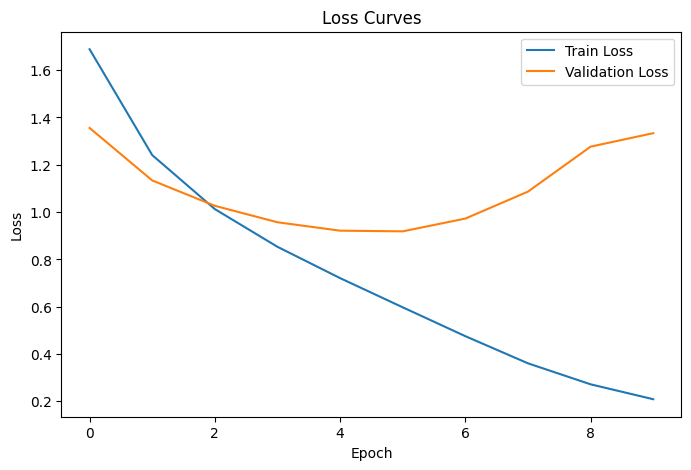

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ✅ That's it , you are done with Task 2